In [1]:
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import QiskitRuntimeService
from sklearn.exceptions import InconsistentVersionWarning

import joblib
import numpy as np
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning,module="qiskit_aer.backends.aer_compiler")
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)


In [2]:
# with open('linear_train.bin','rb') as f:
#     train = joblib.load(f)

# with open('linear_test.bin','rb') as f:
#     test = joblib.load(f)

# with open('linear_scaler.bin','rb') as f:
#     scaler = joblib.load(f)
# X_train, y_train = train['X'],train['y']
# X_test, y_test = test['X'],test['y']


# with open('PCA5_0.8_Morgan_train.bin','rb') as f:
#     bse_train = joblib.load(f)

# with open('PCA5_0.8_Morgan_test.bin','rb') as f:
#     bse_test = joblib.load(f)

# with open('PCA5_0.8_Morgan_scaler.bin','rb') as f:
#     bse_scaler = joblib.load(f)

# X_bse_train, y_bse_train = bse_train['X'],bse_train['y']
# X_bse_test, y_bse_test = bse_test['X'],bse_test['y']


# X_bse_train[np.isclose(X_bse_train,1)]=1
# X_bse_train[np.isclose(X_bse_train,-1)]=-1



# X_train, y_train = X_bse_train, y_bse_train
# X_test, y_test = X_bse_test, y_bse_test
# scaler = bse_scaler



with open('0.1_5_DDCC_train.bin','rb') as f:
    ddcc_train = joblib.load(f)

with open('0.1_5_DDCC_test.bin','rb') as f:
    ddcc_test = joblib.load(f)

with open('0.1_5_DDCC_scaler.bin','rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(-1,64,5)
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)
y_ddcc_train = y_ddcc_train.reshape(-1,64)
y_ddcc_test = y_ddcc_test.reshape(-1,64)


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test
scaler = ddcc_scaler

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(19, 64, 5) (40, 64, 5)
(19, 64) (40, 64)


In [3]:
backend='Fake'
# Select backend
if backend=='Real':
    service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
    _backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
else:
    _backend = FakeQuebec()


In [4]:
from serverless_run.transpile_remote import transpile_remote
from serverless_run.circuit import circuit
from serverless_run.machine_learning import run

In [5]:
num_qubits = 5
RUD = 3

In [6]:
initial_circuit = circuit(num_qubits,RUD)
qc, mapped_observables = transpile_remote(initial_circuit,_backend)

num_params = len([i for i in list(qc.parameters) if 'theta' in i.name]) // RUD
generator = np.random.default_rng(12958234)
load_params = None

if load_params!=None:
    print('Parameters loaded')
    x0 = np.load(load_params)['x']
else:
    print('Parameters from scratch')
    x0 = np.tile(generator.uniform(-np.pi, np.pi, num_params),RUD)

Parameters from scratch


/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/qiskit_aer/noise/errors/quantum_error.py:322: DeprecationWarning: The property ``qiskit.circuit.instruction.Instruction.condition`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  if inst.operation.condition:


Submitted to device in 74.8626 s


Running batch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.17s/it]


Predicted in 22.4480 s
Iters. done: 1 Current cost: 0.1458909078164183 Accuracy: -3.973797108635194e+29 Time: 98.16081966098864
Now scoring model... 
Submitted to device in 87.1034 s


Running batch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:23<00:00,  1.24s/it]


Predicted in 23.8205 s
Submitted to device in 210.2687 s


Running batch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.16it/s]


Predicted in 18.7726 s
Scoring complete taking 343.1158518791199 seconds. 


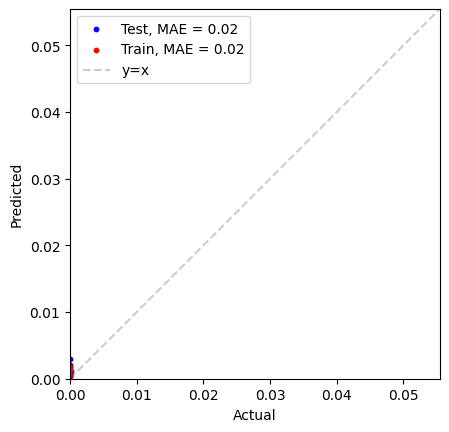

In [7]:
run(x0,qc,mapped_observables,num_qubits,X_train,y_train,X_test, y_test,scaler,_backend,n_jobs=-1)

In [ ]:
from qiskit_serverless import get_arguments, save_result, distribute_task, get

arguments = get_arguments()
circuit = arguments.get("circuit")
optimization_level = arguments.get("optimization_level")
backend = arguments.get("backend")

transpile_worker_reference = transpile_remote(
    circuit,
    optimization_level,
    backend
)
result = get(transpile_worker_reference)
save_result(result)

transpile_worker_references = [
    transpile_remote(circuit, optimization_level, backend)
    for circuit in arguments.get("circuit_list")
]

results = get(transpile_worker_references)
save_result(results)  # Overwrites any previously saved results

@distribute_task(target={
    "cpu": 16,
    "mem": 2 * 1024 * 1024 * 1024
})
def transpile_remote(circuit, optimization_level, backend):
    return None